# Tutorial 01

## assembling the ABS pipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import logging as log
import afra as af
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#log.basicConfig(filename='abspy_tutorial02.log', level=log.DEBUG)

#### generate maps with pysm3

In [2]:
NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map30 = hp.smoothing(map30f+mapcmb,fwhm=fwhm[0],verbose=0)
map95 = hp.smoothing(map95f+mapcmb,fwhm=fwhm[1],verbose=0)
map150 = hp.smoothing(map150f+mapcmb,fwhm=fwhm[2],verbose=0)
map353 = hp.smoothing(map353f+mapcmb,fwhm=fwhm[3],verbose=0)

#### use `abspipe` (short for ABS pipeline) with map matrix input

#### `abspipe` (initialization/instantiation) Parameters: 

**singals** : dict
> The full collection of measurements in pixel domain,
  arranged in form {frequency (GHz): array(N_map, N_pixel)}.
    - N_map: number of maps at each frequency
    - N_pixel: number of pixels of each map
    
**variances** : dict
> The measured noise variance maps,
  should be arranged in the same shape as **signal**.
  By default, no variance maps required.
  
**mask** : numpy.ndarray
> Single mask map,
  should be arranged in shape: (1, N_pixel),
  By default is None, which means no masking.

**fwhms** : list
> Gaussian beams with given FWHM at each frequency band
            
**lmax** : integer
> Maximal multiple in PS estimation.

#### the `__call__` or `abspipe::run()` function parameters:

**aposcale** : float
> Apodization scale for PS estimation.

**psbin** : integer
> number of angular modes in each $\ell$-bin for pseudo-$C_\ell$ estimation

**shift** : float
> ABS method (CMB signal) shift parameter.

**threshold** : float
> ABS method signal-to-noise threshold parameter.

#### `abspipe::__call__` or `abspipe::run()` returns

**result** : numpy.ndarray
> The first row contains angular mode positions, while the second row contains the PS band power $D_\ell$ at corresponding multipoles.

> If `verbose=True`, then the **result** contains an extra dictionary of eigen values and eigen vectors for each multipole, in form {multipole index : (eigen values, eigen vectors)}.

- apply to T maps

CPU times: user 33.4 s, sys: 141 ms, total: 33.6 s
Wall time: 8.8 s


(1, 384)

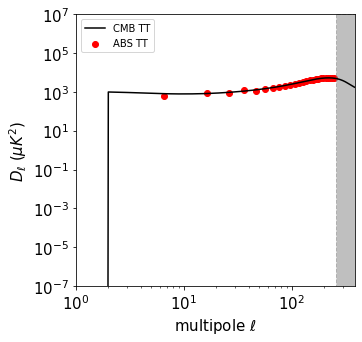

In [3]:
%%time

fullmap = dict()
fullmap[30] = map30[0].reshape(1,-1)
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)
fullmap[353] = map353[0].reshape(1,-1)

pipeline = af.abspipe(fullmap,fwhms=fwhm)
rslt_tt = pipeline(aposcale=6.,psbin=10,shift=None,threshold=None,verbose=True)

fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(rslt_tt[0],rslt_tt[1],
           color='red',marker='o',label=r'ABS TT')

ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[0],
        color='black',linestyle='-',label=r'CMB TT')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

- check the eigens in cross-correlated PS band power

the eigen values and vectors are returned as a python dict, attached to the normal return of pipeline's `__call__` function, in form: `{mode #: (eigen value, eigen vector)}`

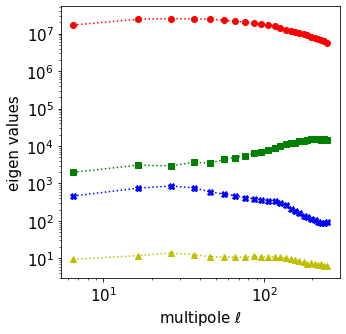

In [4]:
fig,ax = plt.subplots(figsize=(5,5))
freq_list = [30,95,150,353]

eigens = np.empty((len(freq_list),len(rslt_tt[0])))
for i in range(eigens.shape[1]):
    eigens[:,i] = rslt_tt[-1][i][0]

ax.plot(rslt_tt[0],eigens[0],linestyle=':',color='r',marker='o')
ax.plot(rslt_tt[0],eigens[1],linestyle=':',color='g',marker='s')
ax.plot(rslt_tt[0],eigens[2],linestyle=':',color='b',marker='X')
ax.plot(rslt_tt[0],eigens[3],linestyle=':',color='y',marker='^')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

- check with Q,U maps

CPU times: user 1min 29s, sys: 703 ms, total: 1min 30s
Wall time: 23 s


(1, 384)

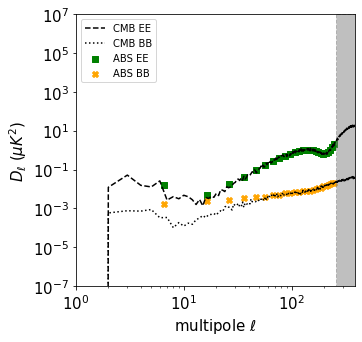

In [5]:
%%time

fullmap.clear()
fullmap[30] = map30[1:3]
fullmap[95] = map95[1:3]
fullmap[150] = map150[1:3]
fullmap[353] = map353[1:3]

pipeline = af.abspipe(fullmap,fwhms=fwhm)
rslt_eb = pipeline(aposcale=6.,psbin=10,shift=None,threshold=None)

fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(rslt_eb[0],rslt_eb[1],
           color='green',marker='s',label=r'ABS EE')
ax.scatter(rslt_eb[0],rslt_eb[2],
           color='orange',marker='X',label=r'ABS BB')

cmb_cl = hp.anafast(mapcmb)
ell = np.arange(cmb_cl.shape[1])
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[1],
        color='black',linestyle='--',label=r'CMB EE')
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[2],
        color='black',linestyle=':',label=r'CMB BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

- B mode only, with EB leakage correction done before PS estimation

CPU times: user 57.2 s, sys: 80.6 ms, total: 57.3 s
Wall time: 14.4 s


(1, 384)

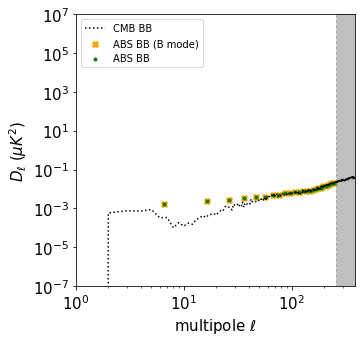

In [6]:
%%time

fullmap.clear()
fullmap[30] = map30
fullmap[95] = map95
fullmap[150] = map150
fullmap[353] = map353

pipeline = af.abspipe(fullmap,fwhms=fwhm)
rslt_b = pipeline.run_bmode(aposcale=6.,psbin=10,shift=None,threshold=None)

fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(rslt_b[0],rslt_b[1],
           color='orange',marker='X',label=r'ABS BB (B mode)')

ax.scatter(rslt_eb[0],rslt_eb[2],
           color='green',marker='.',label=r'ABS BB')

ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[2],
        color='black',linestyle=':',label=r'CMB BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

#### comments:

The "bias" seen at low multiple B mode spectrum appears to be caused by the Milky Way disk contamination.

end